In [1]:
#import libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
import xgboost as xgb
import seaborn as sns

#prepare the data
def my_data_preparation(train_data):
    #merge training and store data
    all_data = pd.merge(train_data, store_data, how = 'left', on = 'Store')
    #convert 'Date' to datetime format
    all_data['Date'] = pd.to_datetime(train_data['Date'])
    #extract year, month, day of month, and week of year
    all_data['Year'] = all_data['Date'].dt.year
    all_data['Month'] = all_data['Date'].dt.month
    all_data['Day'] = all_data['Date'].dt.day
    all_data['WeekOfYear'] = all_data['Date'].dt.isocalendar().week.astype(np.int64)
    #fix type errors in the 'StateHoliday' column
    all_data['StateHoliday'] = all_data['StateHoliday'].replace(0.0, '0')
    #dummy encode all categorical data
    all_data = pd.get_dummies(all_data, columns = ['StoreType', 'Assortment', 'StateHoliday'])
    #select only columns with numerical data
    all_data = all_data.select_dtypes(include=np.number)
    #drop columns with too many nans and drop the 'Customers' column
    all_data = all_data.drop(columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Customers'])
    return all_data

#load data files
store_data = pd.read_csv("./data/store.csv")
train_data = pd.read_csv("./data/train.csv")
holdout_data_0 = pd.read_csv("./data/holdout_b29.csv")
#prepare the data
all_data = my_data_preparation(train_data)
all_holdout_data = my_data_preparation(holdout_data_0)
print(f'store_data.shape: {store_data.shape}')
print(f'train_data.shape: {train_data.shape}')
print(f'all_data.shape: {all_data.shape}')
#list of features
features =  ['Store', 'DayOfWeek', 'WeekOfYear', 'Month', 'Open', 'Promo', 'SchoolHoliday', 
             'CompetitionDistance', 'Promo2', 
             'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
             'Assortment_a', 'Assortment_b', 'Assortment_c',
             'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
#list of features and target, the target is 'Sales'
features_and_target = list(features)
features_and_target.append('Sales')
print(features_and_target)
#drop all rows with nans in the relevant columns
numeric_data = all_data.dropna(axis = 0, subset = features_and_target)
#drop all rows with vanishing sales
numeric_data = numeric_data.loc[numeric_data['Sales'] != 0.0]
data = numeric_data
print(f'data.shape: {data.shape}')
#specify target and features
y = data.loc[:, 'Sales']
X = data.loc[:, features]
#set up the target encoder
#we target encode only the 'Store' column
ce_te = ce.TargetEncoder(cols = 'Store')
#find transform for target encoding
ce_te.fit(X, y)
#transform features
X = ce_te.transform(X)
#split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#specify features for the holdout data
holdout_data = all_holdout_data.loc[:, features]
#transform the holdout data
X_holdout = ce_te.transform(holdout_data)

/home/jakob/anaconda3/envs/minicomp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


store_data.shape: (1115, 10)
train_data.shape: (637774, 9)
all_data.shape: (637774, 23)
['Store', 'DayOfWeek', 'WeekOfYear', 'Month', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'Sales']
data.shape: (438993, 23)


In [ ]:
numeric_data.shape: (438993, 23)

In [2]:
#How often are 'Sales' zero when shops are open?
shop_open = train_data.loc[train_data['Open'] == 1.0].dropna(axis = 0, subset = ['Sales'])
shop_open_zero_sales = shop_open.loc[shop_open['Sales'] == 0.0 ]
shop_open_zero_sales['Sales'].value_counts()

0.0    40
Name: Sales, dtype: int64

In [3]:
train_data['StateHoliday'].dropna().unique()

array(['a', '0', 'b', 'c', 0.0], dtype=object)

<AxesSubplot:>

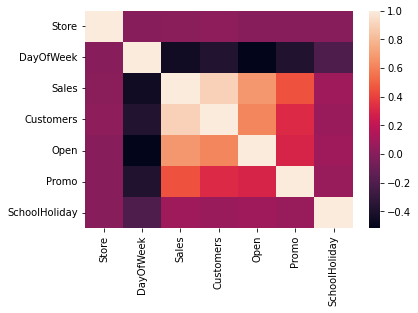

In [4]:
#plot the heat map of correlations in the training data
sns.heatmap(train_data.select_dtypes(include=np.number).corr())

<AxesSubplot:>

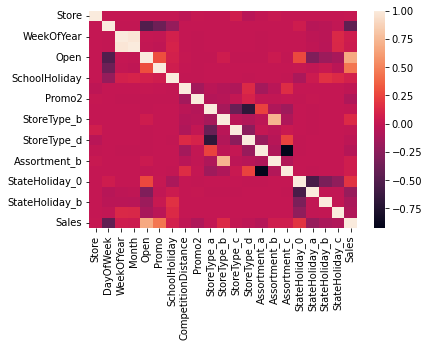

In [5]:
#plot the heat map of correlations in the dummy encoded data
sns.heatmap(all_data[features_and_target].corr())

<AxesSubplot:>

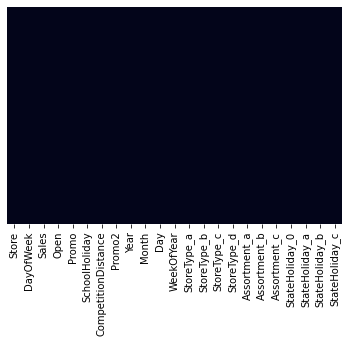

In [6]:
#check viusally for nan values
sns.heatmap(data.isnull(), yticklabels= False, cbar= False)

In [7]:
#XGBoost regression
#set up xgb regressor
xgbr = xgb.XGBRegressor(max_depth=250,learning_rate=0.2,n_estimators=150,n_jobs=10, 
                        colsample_bytree=0.4,subsample=0.7,reg_alpha=10,reg_lambda=20)
#fit the training data
xgbr.fit(X_train, y_train)
#xgb prediction on the test data
predict_test = xgbr.predict(X_test)
#xgb prediction on the test data
predict_train = xgbr.predict(X_train)
#compute xgb score
print(f'xgbr Score: {xgbr.score(X_test, y_test)}')
#compute xgb test RMSE
print(f'xgbr test RMSE: {sqrt(mean_squared_error(y_test, predict_test))}')
#compute xgb train RMSE
print(f'xgbr train RMSE: {sqrt(mean_squared_error(y_train, predict_train))}')
#compute xgb test RMSPE
diff = 1 - predict_test/y_test
RMSPE = sqrt(np.dot(diff,diff)/len(diff))
print(f'xgbr test RMSPE: {RMSPE}')
#compute xgb train RMSPE
#diff = 1 - predict_train/y_train
#RMSPE = sqrt(np.dot(diff,diff)/len(diff))
#print(f'xgbr train RMSPE: {RMSPE}')

xgbr Score: 0.932936472519551
xgbr test RMSE: 802.04472955627
xgbr train RMSE: 576.2050108486645
xgbr test RMSPE: 0.16122761297896568


In [ ]:
xgbr test RMSPE: 0.16122761297896557

/tmp/ipykernel_20327/8395875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Prediction']=predict_test
/tmp/ipykernel_20327/8395875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Sales']=y_test


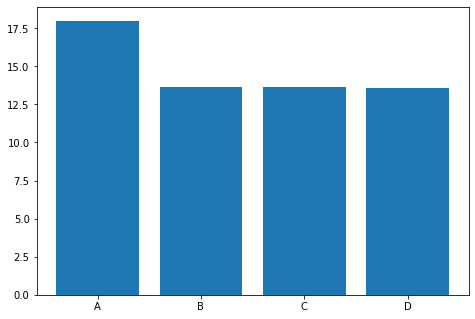

In [9]:
X_test['Prediction']=predict_test
X_test['Sales']=y_test
test_results=X_test
Store_a = test_results[test_results.StoreType_a == 1]
Store_b = test_results[test_results.StoreType_b == 1]
Store_c = test_results[test_results.StoreType_c == 1]
Store_d = test_results[test_results.StoreType_d == 1]
def metric(a,b):
    diff = 1 - a/b
    return sqrt(np.dot(diff,diff)/len(diff))
error_Sa=100*metric(Store_a.iloc[:,-2],Store_a.Sales)
error_Sb=100*metric(Store_b.iloc[:,-2],Store_b.Sales)
error_Sc=100*metric(Store_c.iloc[:,-2],Store_c.Sales)
error_Sd=100*metric(Store_d.iloc[:,-2],Store_d.Sales)
errorz=[error_Sa,error_Sb,error_Sc,error_Sd]
#error_by_storetype={“A”:error_Sa,“B”:error_Sb,“C”:error_Sc,“D”:error_Sd}
error_by_storetype = ["A","B","C","D"]
Store_a_train = X_train[X_train.StoreType_a == 1]
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.bar(error_by_storetype, errorz)
plt.show()

In [ ]:
#xgb prediction for the holdout data
predict_holdout = xgbr.predict(X_holdout)
#generate 'ID' column for submission on kaggle
Ids = holdout_data_0.iloc[:, 0] + 1
#set up Data Frame which holds the 'Id' and 'Sales' columns
d = {'Id': Ids, 'Sales': predict_holdout}
df_holdout = pd.DataFrame(data = d)
#write holdout predition to a csv file
df_holdout.to_csv("data/predict_holdout.csv",index=False)
print(df_holdout.shape)

In [5]:
print(df_holdout.tail())

            Id        Sales
315535  379431  7148.440430
315536  379432  9501.898438
315537  379433  6360.952148
315538  379434  8749.410156
315539  379435  5050.416016
